# Notebook pour la visualisation des coraux selon leur position
Installation de :
- jupyter-lab
- sklearn
- pandas
- geopandas
- matplotlib
- numpy


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import DBSCAN
import numpy as np 
import pandas as pd


# Lecture des données + planisphère

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coraux = gpd.read_file('../data/out/coraux_geo.geojson')

# Affiche tous les coraux sur un planisphère
1 couleur == 1 type de corail

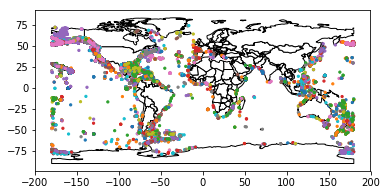

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
base = world.plot(ax=ax, color='white', edgecolor='black')
coraux.plot(ax=ax, marker='o', markersize=5, column="ScientificName")
plt.show();

# Affiche quelques infos des coraux

In [11]:
print(coraux.head())
nb_coraux_unique = len(coraux.ScientificName.unique())
print("\n Le nombre de coraux est de {} pour {} espèces".format(len(coraux.ScientificName), nb_coraux_unique))
print("\n La répartition est :\n{}".format(coraux.ScientificName.value_counts()))

   CatalogNumber     ScientificName   VernacularNameCategory TaxonRank  \
0         625366  Madrepora oculata  stony coral (branching)   species   
1         625373  Madrepora oculata  stony coral (branching)   species   
2         625386  Madrepora oculata  stony coral (branching)   species   
3         625382  Madrepora oculata  stony coral (branching)   species   
4         625384  Madrepora oculata  stony coral (branching)   species   

   latitude  longitude  DepthInMeters  \
0  18.30817 -158.45392            959   
1  18.30864 -158.45393            953   
2  18.30877 -158.45384            955   
3  18.30875 -158.45384            955   
4  18.30902 -158.45425            968   

                                   Locality  phosphate.csv  oxygen.csv  \
0  Hawaiian Archipelago, Swordfish Seamount       3.141286    1.066357   
1  Hawaiian Archipelago, Swordfish Seamount       3.141286    1.066357   
2  Hawaiian Archipelago, Swordfish Seamount       3.141286    1.066357   
3  Hawaiian 

# Filtrer/ Réduire le nombre de données pour test
- Ne garde que les n coraux qui ont un nombre max de d'échantillons
- Juste pour tester des fonctions et réduire les temps de calcul

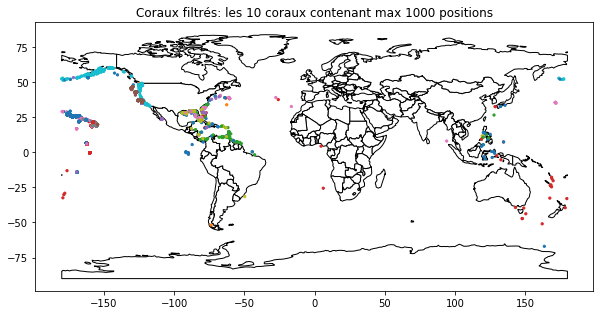

In [12]:
fig, ax = plt.subplots(figsize=[10, 6])
ax.set_aspect('equal')
# coraux.ScientificName.value_counts().keys().tolist() #keys
# coraux.ScientificName.value_counts().tolist() ## value
counts = coraux['ScientificName'].value_counts()

nb_de_data_max = 1000
nb_coraux_filtres = 10
coraux_filtres = coraux[coraux['ScientificName'].isin(counts[counts <nb_de_data_max].index[:nb_coraux_filtres])]
base = world.plot(ax=ax, color='white', edgecolor='black')
coraux_filtres.plot(ax=ax, marker='o', markersize=5, column="ScientificName")
ax.set_title('Coraux filtrés: les {} coraux contenant max {} positions'.format(nb_coraux_filtres, nb_de_data_max))
plt.show();

# Regroupe les positions par coraux selon leur densité 

In [13]:
coords = coraux_filtres.as_matrix(columns=['latitude', 'longitude'])
kms_per_radian = 6371.0088
epsilon = 1000 / kms_per_radian #
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) 
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))


c:\users\elodie\programmation\python\python3.5.4\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Number of clusters: 8


c:\users\elodie\programmation\python\python3.5.4\lib\site-packages\geopandas\plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
c:\users\elodie\programmation\python\python3.5.4\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0) 0
1 (0.8853517877739331, 0.3190311418685121, 0.29042675893886966, 1.0) 0
2 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469, 1.0) 0
3 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866, 1.0) 0
4 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243, 1.0) 0
5 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541, 1.0) 5
6 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197, 1.0) 0
-1 [0, 0, 0, 1] 46


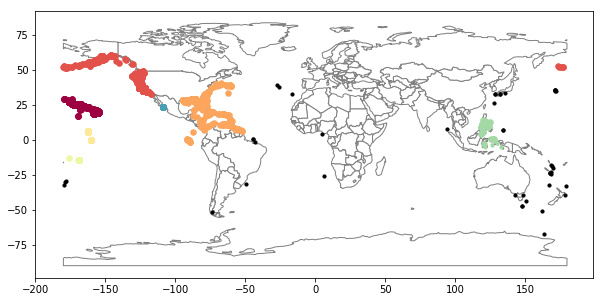

In [14]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Black removed and is used for noise instead.
labels = cluster_labels
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=[10, 6])
base = world.plot(ax=ax, color='white', edgecolor='gray')
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = coraux_filtres[class_member_mask & core_samples_mask]
    xy.plot(ax=ax, marker='o',color=col, markersize=30, column="ScientificName")
    xy = coraux_filtres[class_member_mask & ~core_samples_mask]
    xy.plot(ax=ax, marker='o',color=col, markersize=10, column="ScientificName")
    print(k, col, len(xy))
plt.show()   

# Regroupe les positions par coraux selon leur densité selon l'espèce
1 couleur == 1 région contenant une densité de coraux satisfaisantes

Number of clusters: Chrysogorgia sp. 7 {0, 1, 2, 3, 4, 5, -1}
	Chrysogorgia sp. 0 818 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Chrysogorgia sp. 1 88 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Chrysogorgia sp. 2 12 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
	Chrysogorgia sp. 3 23 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
	Chrysogorgia sp. 4 15 (0.9977700884275279, 0.930872741253364, 0.6330642060745867, 1.0)
	Chrysogorgia sp. 5 24 (0.944252210688197, 0.9777008842752788, 0.6620530565167244, 1.0)
	Chrysogorgia sp. -1 6 [0, 0, 0, 1]


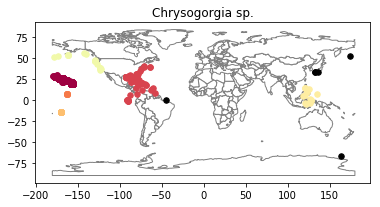

Number of clusters: Desmophyllum sp. 2 {0, -1}
	Desmophyllum sp. 0 845 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Desmophyllum sp. -1 8 [0, 0, 0, 1]


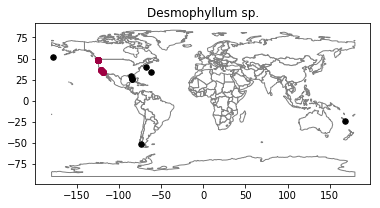

Number of clusters: Ellisella sp. 2 {0, -1}
	Ellisella sp. 0 920 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Ellisella sp. -1 6 [0, 0, 0, 1]


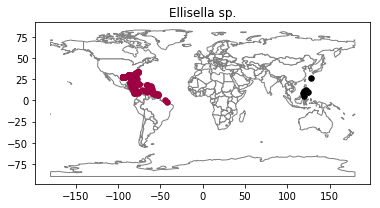

Number of clusters: Enallopsammia rostrata 4 {0, 1, 2, -1}
	Enallopsammia rostrata 0 948 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Enallopsammia rostrata 1 13 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Enallopsammia rostrata 2 10 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
	Enallopsammia rostrata -1 26 [0, 0, 0, 1]


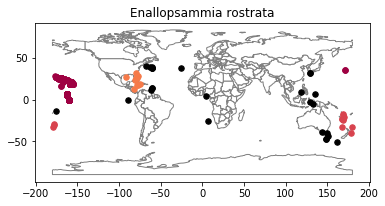

Number of clusters: Euplectellidae 5 {0, 1, 2, 3, -1}
	Euplectellidae 0 13 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Euplectellidae 1 30 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Euplectellidae 2 873 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733, 1.0)
	Euplectellidae 3 24 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587, 1.0)
	Euplectellidae -1 2 [0, 0, 0, 1]


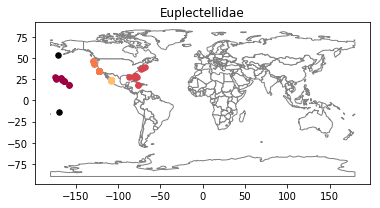

Number of clusters: Farrea truncata 2 {0, -1}
	Farrea truncata 0 869 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Farrea truncata -1 4 [0, 0, 0, 1]


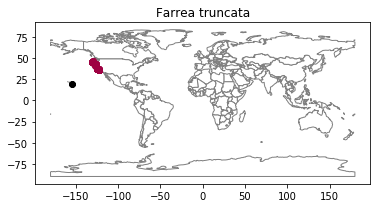

Number of clusters: Leiopathes sp. 3 {0, 1, -1}
	Leiopathes sp. 0 331 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Leiopathes sp. 1 581 (0.8472126105344099, 0.2612072279892349, 0.30519031141868513, 1.0)
	Leiopathes sp. -1 3 [0, 0, 0, 1]


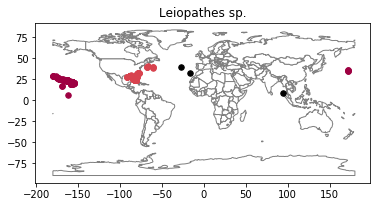

Number of clusters: Lepidisis olapa 1 {0}
	Lepidisis olapa 0 910 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)


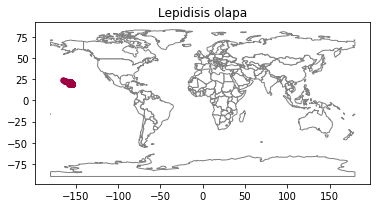

Number of clusters: Nicella sp. 2 {0, -1}
	Nicella sp. 0 833 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
	Nicella sp. -1 3 [0, 0, 0, 1]


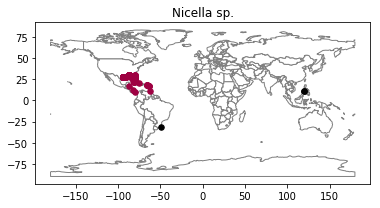

Number of clusters: Ptilosarcus gurneyi 1 {0}
	Ptilosarcus gurneyi 0 887 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)


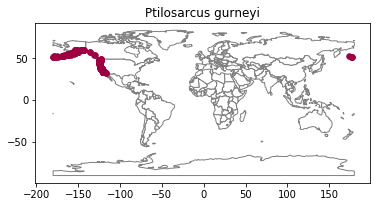

10


In [15]:
grouped = coraux_filtres.groupby('ScientificName')


nb=0
for name, group in grouped:
    coords = group[['latitude', 'longitude']] 
    kms_per_radian = 6371.0088
    epsilon = 1500 / kms_per_radian #1.5
    db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords)) 
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    
    if not(num_clusters == 1 and set(cluster_labels) == set([-1])):
        print('Number of clusters: {} {} {}'.format(name, num_clusters, set(cluster_labels)))
        # Affiche le résultat
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True

        # Black removed and is used for noise instead.
        labels = cluster_labels
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, nb_coraux_filtres)]
        fig, ax = plt.subplots()#figsize=[10, 6])
        base = world.plot(ax=ax, color='white', edgecolor='gray')
        for k, col in zip(unique_labels, colors):
            col = [0, 0, 0, 1] if k == -1 else col
            class_member_mask = (labels == k)
            xy = group[(class_member_mask & core_samples_mask) | (class_member_mask & ~core_samples_mask)]
            #print(xy.head())
            print('\t{} {} {} {}'.format(name, k, len(xy), col))
            if len(xy) > 0:
                xy.plot(ax=ax, marker='o', color=col, markersize=30)#, column="ScientificName")
                ax.set_title('{}'.format(name))
        plt.show() 
        nb = nb+1
    
    #print name
print(nb)